In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
import sys, os
# !{sys.executable} -m pip install aplpy
import numpy as np
# import aplpy
from astropy.table import Table
# !pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

!pip install photutils
import photutils
from photutils.aperture import aperture_photometry, CircularAperture

import warnings
warnings.filterwarnings('ignore')

import urllib.request
import pandas as pd


font = {'weight': 'regular', 
        'size': 16}
font2 = {'weight': 'regular', 
        'size': 12}

In [2]:
# Functions

# Function to CHECK IF RAS AND DECS ARE IN AN IMAGE
def check_in_image(SNras, SNdecs, SNnames, SNtypes, GalaxyImg):
    
#     for i in range(len(SNnames)):
#         if SNnames[i] == "SN1983V":
#             SNtypes[i] = "Ic"
    
    hdulist = pyfits.open(GalaxyImg)
    map = hdulist[1].data
    wcs = WCS(hdulist[1].header, naxis=0)
    #print(wcs._naxis)
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)
    naxis = wcs._naxis #size of image
    naxis1 = hdulist[1].header['NAXIS1']
    naxis2 = hdulist[1].header['NAXIS2']
    is_in_x = (pix_x >= 0) & (pix_x <= naxis1-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis2-1)
        
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]  
    
    c_delt = hdulist[1].header['CDELT1']
    dist = 17.69 * 10**6 # Handcoded just for 1566 for now until I know how to find this in file
    theta1kpc = np.arctan((1000./dist)*(180./np.pi)) # theta for 1kpc scalebar
    theta100pc = np.arctan((100./dist)*(180./np.pi)) # theta for 1kpc scalebar

    return (name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord, map, naxis1, naxis2, c_delt, dist, theta1kpc, theta100pc)


In [3]:
# grab list of files and SN data

# prefix = "/home/maykerchen.1/Desktop/"
# prefix = "/Users/mayker.1/Desktop/"
prefix = "/Users/nessmayker/Desktop/"

fileList = prefix + "SNeJWST/Data/filelist1566.txt"
fileNames = np.genfromtxt(fileList, dtype=str, unpack=True, usecols=(0))
fileNames = [prefix + "JWSTLargeFiles/ngc1566_v0p6alpha/" + x for x in fileNames]

SNname = "SN2021aefx"
SNtype = "Ia"
SNra   = 64.9725
SNdec  = -54.94808055555555


In [4]:
# set up plots & wcs information.
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.wcs import WCS
plots, wcss, hdus, names, types, ras, decs, xs, ys, maps, nax1s, nax2s, cds, dist = [],[],[],[],[],[],[],[],[],[],[],[],[],[]
scalebars, cutoutsbs =[],[]

for i in range(len(fileNames)):
    if os.path.isfile(fileNames[i]):
        ns, ts, rs, ds, xcs, ycs, ms, n1s, n2s, cd, d, tkpc, tpc = check_in_image(SNra, SNdec, SNname, SNtype, 
                                                                                  fileNames[i])
        names.append(ns)
        types.append(ts)
        ras.append(rs)
        decs.append(ds)
        xs.append(xcs)
        ys.append(ycs)
        maps.append(ms)
        nax1s.append(n1s)
        nax2s.append(n2s)
        cds.append(cd)
        dist.append(d)
        JWST_hdu = pyfits.open(fileNames[i])
        hdus.append(JWST_hdu)
        JWST_map = JWST_hdu[1].data
        plots.append(JWST_map)
        wcss.append(WCS(JWST_hdu[1].header, naxis=2))
        cdelt_as = cd * 3600
        t_as     = tkpc  * 3600
        t_as_cutout = tpc *  3600
        t_as = np.round(t_as,1)
        t_as_cutout =  np.round(t_as_cutout,1)
#         cdelt_pc = d * np.tan(cd*np.pi/180)       
#         sb = ScaleBar(cdelt_pc,"m",dimension="si-length",label="1 kpc",length_fraction=None,fixed_value=1000,
#                       location="lower right",color='white',pad=None, box_alpha=0, font_properties=font, scale_loc = None)
        sb = ScaleBar(cdelt_as,"''",dimension="angle",label="1 kpc",length_fraction=None,fixed_value=t_as,
                      location="lower left",color='black',pad=0.2, box_alpha=0.7, font_properties=font, scale_loc = None)
        scalebars.append(sb)
        sb_co = ScaleBar(cdelt_as,"''",dimension="angle",label="100 pc",length_fraction=None,fixed_value=t_as_cutout,
                      location="lower left",color='black',pad=0.2, box_alpha=0.7, font_properties=font2, scale_loc = None)
        cutoutsbs.append(sb_co)

print(types)

[array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2'), array(['Ia'], dtype='<U2')]


In [5]:
# set up legend labels

legendLabels = []

for i in range(len(names)):
    legendlabel = []
        
    if len(names[i]) > 1:
        for k in range(len(names[i])):
            if types[i][k] == 'unclassified' or types[i][k] == 'Unclassified':
                typelabel = names[i][k] + ' '  + types[i][k]
            else:
                typelabel = names[i][k] + ' Type '  + types[i][k]
            legendlabel.append(typelabel)
    else:
        if types[i][0] == 'unclassified' or types[i][0] == 'Unclassified':
            legendlabel.append(names[i][0] + ' '  + types[i][0]) 
        else:        
            legendlabel.append(names[i][0] + ' Type '  + types[i][0])
    legendLabels.append(legendlabel)

print(legendLabels)


[['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia'], ['SN2021aefx Type Ia']]


In [6]:
# set up plot specifics
from matplotlib.patches import Circle

markerShapes = ["o", "s", "p", "D", "X", "H", "v"]
markerSizes  = [210,150,310,150,330,310,350]
markerEdges  = [410,350,610,350,630,610,650]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

#        1,       2,      3,       4,        5,       6,       7,     8
vmm = [[0.5,35],[0.5,35],[0.5,35],[0.5,35],[0.1,40],[0.1,40],[0.1,40],[0.1,40]]
imgs = ["miri_f770w", "miri_f1000w", "miri_f1130w", "miri_f2100w",
        "nircam_clear-f200w", "nircam_clear-f300m", "nircam_clear-f335m",
        "nircam_clear-f360m"]
titles = ["MIRI 770w", "MIRI 1000w", "MIRI 1130w", "MIRI 2100w",
        "NIRCam 200w", "NIRCam 300m", "NIRCam 335m",
        "NIRCam 360m"]

In [7]:
# get nebular mask ready
# from reproject import reproject_interp

# ngc1365NebFile = '../Data/NGC1566_nebulae_mask_V2.fits'

# neb_hdu = pyfits.open(ngc1365NebFile)
# neb_map = neb_hdu[0].data
# neb_wcs = WCS(neb_hdu[0].header, naxis=2)
# plt.imshow(neb_map)


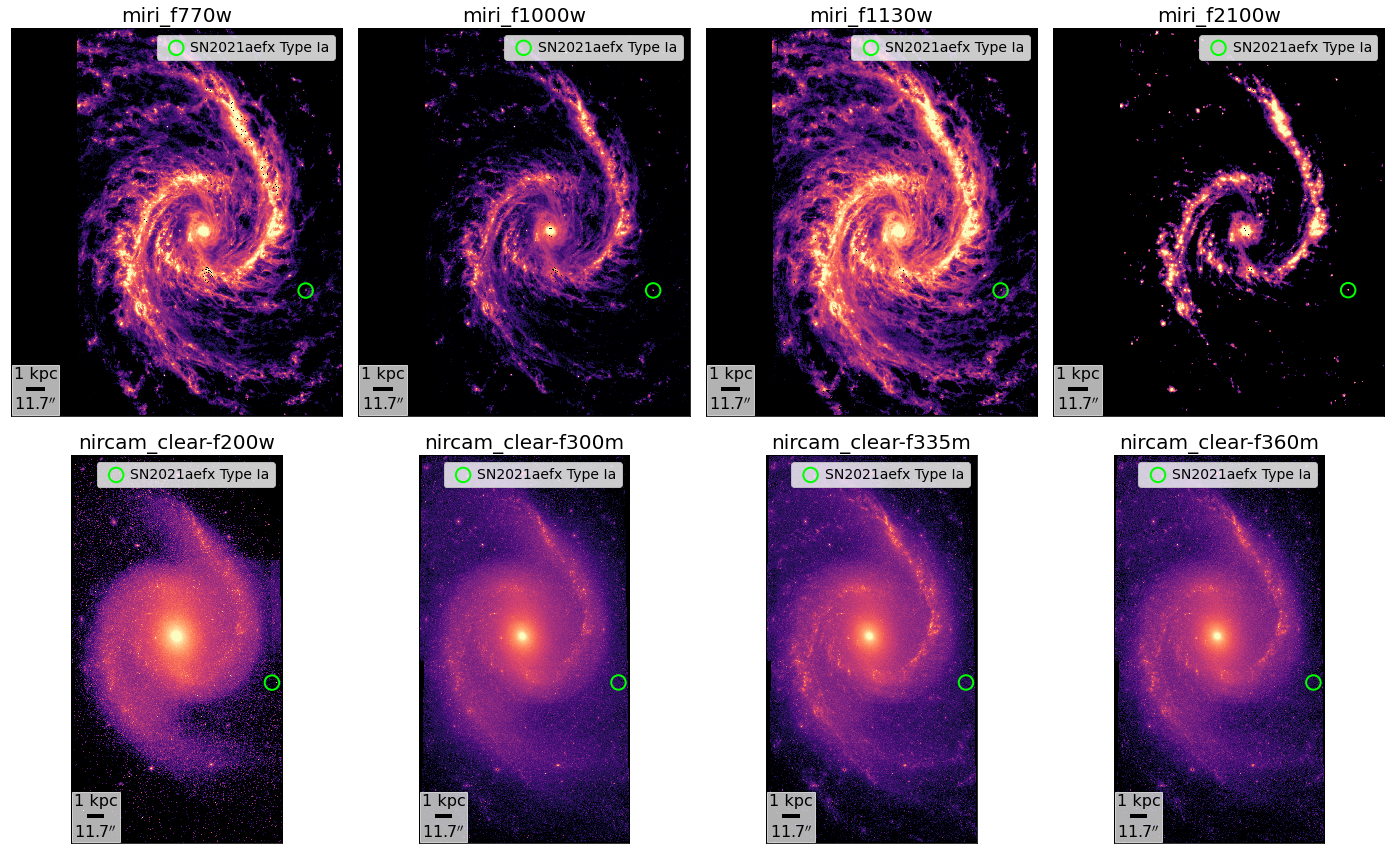

In [8]:
# make multipanel plot  

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(30, 15))

for plot in plots:
    
#     neb_arr, neb_ftp = reproject_interp(neb_hdu, hdus[m][1].header)

    
    xArr, yArr = wcss[m].wcs_world2pix(ras[m],decs[m],0)
    
    logplot = np.log10(plot)
    axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", 
                     origin = "lower", interpolation = "nearest",
                    vmin=np.log10(vmm[m][0]), vmax=np.log10(vmm[m][1]))
    axs[i][j].set_title(imgs[m], fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
      
    for n in range(len(decs[m])):
#         axs[i][j].scatter(xArr[n], yArr[n], color = "black", marker = markerShapes[n], s = markerEdges[n], zorder=2)
        axs[i][j].scatter(xArr[n], yArr[n], facecolor = "none", marker = markerShapes[n], s = markerSizes[n], 
                          edgecolor="lime", linewidth=2, label = legendLabels[m][n], zorder = 2)
    axs[i][j].legend(loc="best", fontsize=14, handletextpad=0.007)
    axs[i][j].add_artist(scalebars[m])
#     axs[i][j].imshow(neb_arr, alpha = 0.2)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m+=1

plt.subplots_adjust(wspace=-0.45, hspace=0.1)
plt.show()
fig.savefig("../Figures/NGC1566allPanels.png", dpi=300)
plt.close()


In [9]:
# Get angular sizes of interest ready

def findAngSize(sphere, dist):
    """ Finds the angular size in decimal degrees when given the 
        size of the sphere in pc and the
        distance to the galaxy in Mpc
    """
    
    angSizeRad = np.arctan(sphere/(dist*10**6))
    angSize = angSizeRad * (180/np.pi)

    return(angSize)

sphereSizes = [10,200,1000]
angSizes = []

dist_to_1566 = 17.69

ang1 = findAngSize(sphereSizes[0], dist_to_1566)
ang2 = findAngSize(sphereSizes[1], dist_to_1566)
ang3 = findAngSize(sphereSizes[2], dist_to_1566)

angSizes.append([ang1, ang2, ang3])



In [10]:
#subplot padding changes

lft = 0.1
btm = 0.1
rht = 0.99
tp  = 0.7
wsp = 0.45
hsp = 0.5
pd  = 0.5
wpd = 3.0
hpd = 0.4

# plotting code
def makeZooms(rows, columns, images, SNra, SNdec, SNname, SNtype, vmm, size=(10,5), log=True):
    m,n,p =0,0,0 # plot counters for total number, rows, columns
    PLOTS_PER_ROW = columns
    numPanels = int(rows*columns)
    figname = SNname
    figname, axs = plt.subplots(math.ceil(numPanels/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=size)
#     fig = plt.figure(figsize = size)

    for j in range(len(images)): # counter to count wavelengths

        #set up data to use astropy's cutout2D to plot subsections of galaxy map
        data = plots[j]
        if log == True:
            data = np.log10(data)
        wcs=wcss[j]

        halfBox = angSizes[0][2] # 1000 pc in decimal degrees
        #cutout2D needs skycoord position to carry units
        ra, dec = Angle(SNra * u.degree), Angle(SNdec * u.degree)
        raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
        position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
        #size = u.Quantity((20,20), u.arcsec) #size is size of box in arcsec 
        size = u.Quantity((halfBox,halfBox), u.degree) #size is size of box in arcsec 
        # make 2D cutout, will assign a new wcs to cutout to keep track of coords
        cutout = Cutout2D(data, position, size, wcs) 
        # use this new wcs when converting to pixels to add additional details to plot
        xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
        y1 = yval * 0.2
        x1 = xval * 0.1

        titleStr = images[j]

        # make plot
#         axs[m][n] = fig.add_subplot(rows,columns,p+1,projection = cutout.wcs)
        if rows == 1:
            
            axs[n].set_title(titleStr, fontsize=14)    
            axs[n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                          interpolation = "nearest", zorder = 0, vmin=np.log10(vmm[m][0]), vmax=np.log10(vmm[m][1]))
#             axs[n].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
            axs[n].scatter(xval, yval, facecolor = 'none', marker = "o", s = 80, edgecolor="lime",linewidth=2,zorder = 2)
            axs[n].set_xlabel("")
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].tick_params(axis = "both", direction = "in", length = 0)
            axs[n].axis('off')
            axs[n].axhline(y1,0.1,0.2, color="white")
            axs[n].text(x1, yval * 0.4, "100pc", color="white", horizontalalignment = 'left', verticalalignment = 'top')
#             axs[n].add_artist(cutoutsbs[j])

            n+=1
            p +=1
            
        else:
            axs[m][n].set_title(titleStr, fontsize=14)    
            axs[m][n].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                             interpolation = "nearest", zorder = 0, vmin=np.log10(vmm[m][0]), vmax=np.log10(vmm[m][1]))
#             axs[m][n].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
            axs[m][n].scatter(xval, yval, facecolor = 'none', marker = "o", s = 80, edgecolor="lime",linewidth=2,zorder = 2)
            axs[m][n].set_xlabel("")
            axs[m][n].set_xticks([])
            axs[m][n].set_yticks([])
            axs[m][n].tick_params(axis = "both", direction = "in", length = 0)
            axs[m][n].axis('off')
            axs[m][n].axhline(y1,0.1,0.2, color="white")
            axs[m][n].text(x1, yval * 0.4, "100pc", color="white", horizontalalignment = 'left', verticalalignment = 'top')
#             axs[m][n].add_artist(cutoutsbs[j])

            n+=1
            if n%PLOTS_PER_ROW==0:
                m+=1
                n=0
            p +=1
        figname.suptitle(SNname + ": " + SNtype, fontsize=20)
        plt.subplots_adjust(left = lft, bottom = btm, right = rht, top = tp, wspace = wsp, hspace = hsp)
    plt.tight_layout(pad=pd, w_pad=wpd, h_pad=hpd)
#     figname.savefig("../Figures/NGC1566_Zooms_" + SNname + ".pdf", dpi=300)
    plt.show()


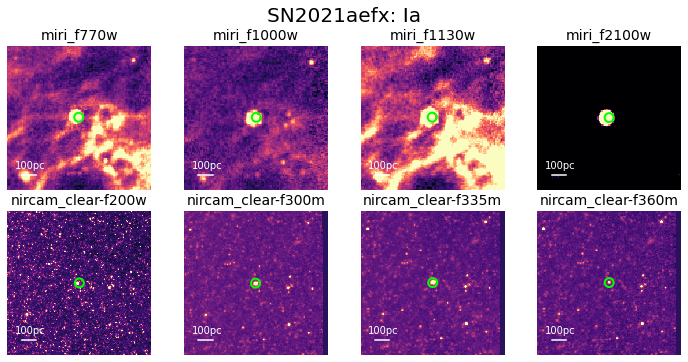

In [11]:
# Zoom plot
vmm = [[0.5,35],[0.5,35],[0.5,35],[0.5,35],[0.1,40],[0.1,40],[0.1,40],[0.1,40]]
makeZooms(2,4, imgs, SNra, SNdec, SNname, SNtype,vmm, log=False)          #SN2021aefx


In [26]:
# Set up photutils and apertures within cutout.

def getPhot(m,coords,rad,img,cdelt):
    xval = coords[0]
    yval = coords[1]
    
    if m > 3:
        halfBox = angSizes[0][1] # 200 pc in decimal degrees
        
    else:
        halfBox = angSizes[0][2] # 1000 pc in decimal degrees
    
    data = plots[m]
    # data = np.log10(data)
    wcs=wcss[m]

    #cutout2D needs skycoord position to carry units
    ra, dec = Angle(SNra * u.degree), Angle(SNdec * u.degree)
    raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
    position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
    size = u.Quantity((halfBox,halfBox), u.degree) #size is size of box in arcsec 
    # make 2D cutout, will assign a new wcs to cutout to keep track of coords
    cutout = Cutout2D(data, position, size, wcs) 

#     xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
#     print(xval,yval)

    ra,dec=cutout.wcs.wcs_pix2world(xval,yval, 0)

    positions = np.transpose((xval, yval)) 
    apertures = CircularAperture(positions, r=rad)  

    phot_table = aperture_photometry(cutout.data, apertures)  

    for col in phot_table.colnames:  

        phot_table[col].info.format = '%.8g'  # for consistent table output

    print(phot_table) 
    angRad = rad * cdelt
    print("radius=",angRad,"decimal degrees")
    print("ra,dec =", ra,dec)

    data = plots[m]
    # data = np.log10(data)
    wcs=wcss[m]
 
    # use this new wcs when converting to pixels to add additional details to plot
    # xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
    y1 = yval * 0.2
    x1 = xval * 0.1

    plt.imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", 
                  interpolation = "nearest", zorder = 0, vmin=np.log10(vmm[m][0]), vmax=np.log10(vmm[m][1]))
    # plt.scatter(xval, yval, facecolor = 'none', marker = "o", s = 80, edgecolor="lime",linewidth=2,zorder = 2)
    apertures.plot(color='lime',zorder=2)
    if m > 3:
        plt.axhline(y1,0.1,0.2, color="white")
        plt.text(xval*0.2, yval * 0.35, "20pc", color="white", horizontalalignment = 'left', verticalalignment = 'top')
    else:
        plt.axhline(yval * 1.8,0.8,0.9, color="white")
        plt.text(xval*1.63, yval * 1.75, "100pc", color="white", horizontalalignment = 'left', verticalalignment = 'top')
        
    plt.axis('off')
    plt.title(titles[m])
    plt.savefig(imgs[m],dpi=300)
    plt.show()
    print(xval,yval,rad,ra,dec,phot_table["aperture_sum"][0],img, angRad)
    return(xval,yval,rad,ra,dec,phot_table["aperture_sum"][0],img, angRad)


 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    49.8    52.8    895.67338
radius= 0.0002156755467818168 decimal degrees
ra,dec = 64.97259849882096 -54.948065671405224


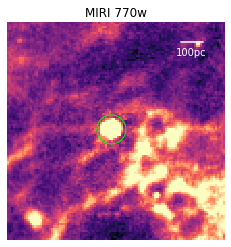

49.8 52.8 7 64.97259849882096 -54.948065671405224 895.6733848565784 miri_f770w 0.0002156755467818168
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    50.1    51.5    562.16354
radius= 0.0002156748446206375 decimal degrees
ra,dec = 64.97261816993179 -54.94810488293807


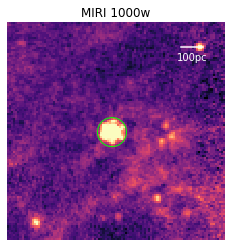

50.1 51.5 7 64.97261816993179 -54.94810488293807 562.1635449836267 miri_f1000w 0.0002156748446206375
 id xcenter  ycenter  aperture_sum
      pix      pix                
--- ------- --------- ------------
  1   49.75 52.362244    728.07598
radius= 0.00026188196354815353 decimal degrees
ra,dec = 64.97260734827537 -54.94808141726634


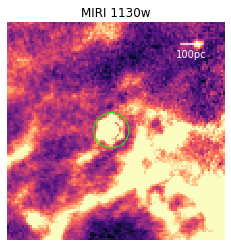

49.75 52.362244 8.5 64.97260734827537 -54.94808141726634 728.0759837065017 miri_f1130w 0.00026188196354815353
 id xcenter  ycenter  aperture_sum
      pix      pix                
--- ------- --------- ------------
  1      50 52.362244    878.46186
radius= 0.0002002628652994424 decimal degrees
ra,dec = 64.97260541778412 -54.948072999159564


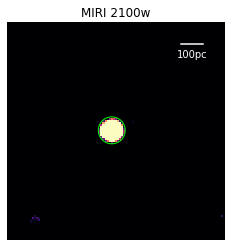

50 52.362244 6.5 64.97260541778412 -54.948072999159564 878.4618557604163 miri_f2100w 0.0002002628652994424
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    32.5    36.5    788.01467
radius= 5.55133041204961e-05 decimal degrees
ra,dec = 64.97257355878881 -54.94808725143115


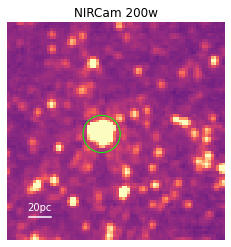

32.5 36.5 6.5 64.97257355878881 -54.94808725143115 788.0146673005055 nircam_clear-f200w 5.55133041204961e-05
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1      18    17.5    149.57199
radius= 7.87483521813429e-05 decimal degrees
ra,dec = 64.97248803809607 -54.94808153022853


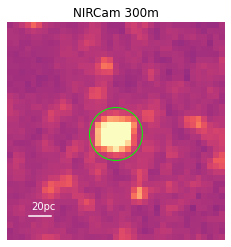

18 17.5 4.5 64.97248803809607 -54.94808153022853 149.57198722890817 nircam_clear-f300m 7.87483521813429e-05
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    18.5   18.75    198.62017
radius= 8.74997706185245e-05 decimal degrees
ra,dec = 64.97249153656645 -54.94807304158542


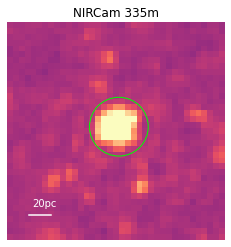

18.5 18.75 5 64.97249153656645 -54.94807304158542 198.62017364850004 nircam_clear-f335m 8.74997706185245e-05
 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    18.5   18.75    50.000289
radius= 6.124985178417665e-05 decimal degrees
ra,dec = 64.97248391937961 -54.94807364631186


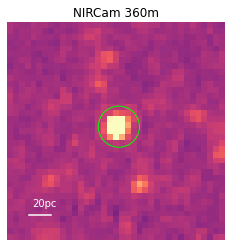

18.5 18.75 3.5 64.97248391937961 -54.94807364631186 50.000288611825546 nircam_clear-f360m 6.124985178417665e-05


In [27]:
#do first image getPhot(img,ra=,dec=,rad=7)

cords = [[49.8,52.8],[50.1,51.5],[49.75,52.362244],[50,52.362244],[32.5,36.5],[18,17.5],[18.5,18.75],[18.5,18.75]]
radii = [7,7,8.5,6.5,6.5,4.5,5,3.5]

xvals,yvals,rads,ras,decs,apertureSums,imgName, angRads = [],[],[],[],[],[],[],[]
for i in range(len(imgs)):
    xval,yval,rad,ra,dec,apertureSum,img,angRad = getPhot(i,cords[i],radii[i],imgs[i],cds[i])
    
    xvals.append(xval)
    yvals.append(yval)
    rads.append(rad)
    ras.append(ra)
    decs.append(dec)
    apertureSums.append(apertureSum)
    imgName.append(img)
    angRads.append(angRad * 3600)
    
ras  = [np.round(x,6) for x in ras]
decs = [np.round(x,6) for x in decs]


In [28]:
# convert the cdelt in decimal degrees to steradian
def find_mJy(apertureSums,cdelt,radius):
    flux = []
    for i in range(len(cdelt)):
        sr_per_pix = cdelt[i]**2 * (np.pi/180.)**2
        total_sr = sr_per_pix #  times radius? times area? 
        flux.append(apertureSums[i] * 10**9 * total_sr) # convert from Mega to milli (* 10^9)
    return(flux)
#flux in Jy
flux = find_mJy(apertureSums,cds,rads)
flux

[0.25900618787925794,
 0.16256248220374464,
 0.21052552859909524,
 0.2540105656524924,
 0.017508803838982744,
 0.013952849865546955,
 0.018528997076399,
 0.0046644585901532126]

In [29]:
# convert flux to solar Luminosity

def find_Lum(flux_mJy,lambda_0,delta_lambda,d_Mpc):

    m_per_Mpc = 3.086 * 10**22     # [m / Mpc]
    ergs_per_Lsun = 3.826 * 10**33 # [erg s-1 / L_sun]
    ergs_per_Jy = 10**(-19)        # [erg⋅s−1⋅m−2⋅Hz−1 / Jy]
    c = 299792458                  # [m/s]
    m_per_micron = 10**(-6)        # [m / micron]

    Nu, Del_Nu, Nu_Lnu, Delta_Lnu = [],[],[],[]
    
    for i in range(len(flux_mJy)):
        flux_Jy   = flux_mJy[i] * 10**(-3) # [Jy]
        flux_ergs = flux_Jy * ergs_per_Jy   # [erg⋅s−1⋅m−2⋅Hz−1]
        L_nu = 4 * np.pi * (d_Mpc)**2 * (m_per_Mpc)**2 * flux_ergs # [erg]
        nu_0 = c/(lambda_0[i] * m_per_micron) # [1/s]
        
        delta_nu = np.abs(c / ((lambda_0[i] + delta_lambda[i]/2.) * m_per_micron) - 
                          c / ((lambda_0[i] - delta_lambda[i]/2.) * m_per_micron))   # [1/s]
        
#         Lam_low = (lambda_0[i] * m_per_micron) - (delta_lambda[i] * m_per_micron) * 0.5
#         Lam_high = (lambda_0[i] * m_per_micron) + (delta_lambda[i] * m_per_micron) * 0.5
#         d_Lam = Lam_high-Lam_low
#         print(d_Lam, delta_lambda[i] * m_per_micron)

        
        
        Nu_L_nu = L_nu * nu_0 # [ergs /s]        
        Delta_nu_L_nu = L_nu * delta_nu # [ergs /s] 
        Nu.append(nu_0 * 10**-13)
        Del_Nu.append(delta_nu * 10**-13)
        Nu_Lnu.append(Nu_L_nu / ergs_per_Lsun * 10**-5)
        Delta_Lnu.append(Delta_nu_L_nu / ergs_per_Lsun * 10**(-5))

    return(Nu, Del_Nu,Nu_Lnu, Delta_Lnu)

delta_lambda = [2.2,2.0,0.7,5.0,0.461,0.318,0.347,0.372] #[microns]
lambda_0 = [7.7,10.0,11.3,21.0,1.990,2.996,3.365,3.621] #[microns]

Nu, Del_Nu, NuLnu, DeltanuLnu = find_Lum(flux, lambda_0,delta_lambda, 17.69)

In [30]:
flux = [np.round(x,3) for x in flux]
aSums = [np.round(x,0) for x in apertureSums]
NuLnu = [np.round(x,3) for x in NuLnu]
DeltanuLnu = [np.round(x,3) for x in DeltanuLnu]
Nu = [np.round(x,3) for x in Nu]
Del_Nu = [np.round(x,3) for x in Del_Nu]
angRads = [np.round(x,3) for x in angRads]

objects = ["PAH, broadband imaging","silicate, broadband imaging","PAH, broadband imaging","broadband imaging",
           "general purpose","Water Ice","PAH, CH4","brown dwarfs, planets, continuum"]
#MIRI770, MIRI1000, MIRI1130, MIRI2100, NC200, NC300, NC335, NC365
AdamFlux = [0.201,0.1520,0.150,0.303,0.0178,0.0125,0.0173,0.00397]
NilsFlux = [0.215,0.132,0.159,0.234,0.0264,0.0116,0.0158,0.00352]


fluxTable = Table({"Image":imgName,
                   "R.A. Center [dec deg]":ras,
                   "Dec Center [dec deg]": decs,
                   "Aperature Radius [arcsec]": angRads,
#                    "Aperature Correction []":,
                   "Aperture Sum [MJy/str]": aSums,
                   "Nu L_nu [10^5 L_sun]": NuLnu,
                   "Delta_nu L_nu [10^5 L_sun]": DeltanuLnu,
                   "Nu [10^13 s^-1]": Nu,
                   "Delta_nu [10^13 s^-1]": Del_Nu,
                   "Ness Flux [mJy]": flux,
                   "Nils Flux [mJy]": NilsFlux,
                   "Adam Flux [mJy]": AdamFlux,})

fluxTable

Image,R.A. Center [dec deg],Dec Center [dec deg],Aperature Radius [arcsec],Aperture Sum [MJy/str],Nu L_nu [10^5 L_sun],Delta_nu L_nu [10^5 L_sun],Nu [10^13 s^-1],Delta_nu [10^13 s^-1],Ness Flux [mJy],Nils Flux [mJy],Adam Flux [mJy]
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
miri_f770w,64.972598,-54.948066,0.776,896.0,9.871,2.879,3.893,1.136,0.259,0.215,0.201
miri_f1000w,64.972618,-54.948105,0.776,562.0,4.77,0.964,2.998,0.606,0.163,0.132,0.152
miri_f1130w,64.972607,-54.948081,0.943,728.0,5.467,0.339,2.653,0.165,0.211,0.159,0.15
miri_f2100w,64.972605,-54.948073,0.721,878.0,3.549,0.857,1.428,0.345,0.254,0.234,0.303
nircam_clear-f200w,64.972574,-54.948087,0.2,788.0,2.582,0.606,15.065,3.537,0.018,0.0264,0.0178
nircam_clear-f300m,64.972488,-54.948082,0.283,150.0,1.367,0.145,10.006,1.065,0.014,0.0116,0.0125
nircam_clear-f335m,64.972492,-54.948073,0.315,199.0,1.616,0.167,8.909,0.921,0.019,0.0158,0.0173
nircam_clear-f360m,64.972484,-54.948074,0.22,50.0,0.378,0.039,8.279,0.853,0.005,0.00352,0.00397


Text(0, 0.5, '$F_\\nu$ [mJy]')

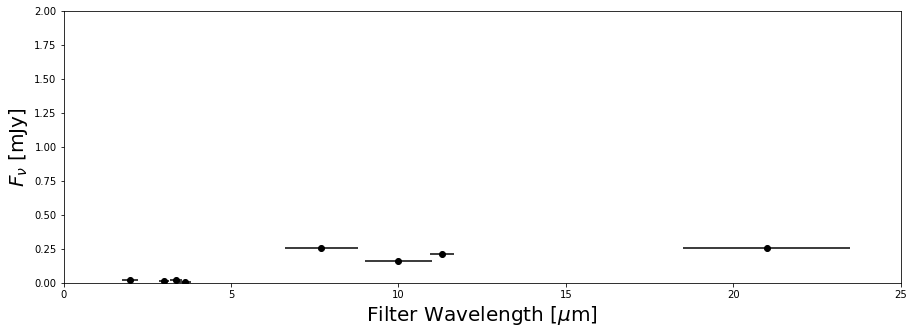

In [74]:
# SED plot 

# yTickMultiplier = [1.5,2.65,3.5,4.7,5.45,6.3,7.35,8.]
# yTicks = [2./x for x in yTickMultiplier]
# xTickMultiplier = [0.9,2.15,3.15,4.75,5.95,8.2,9.75,12,13.6,14.8,15.8,16.6,17.4,18.6,19.6,20.5,21.5,22.5,23.5,24.5]
# xTicks = [22./x for x in xTickMultiplier]
err_lambda = [x/2. for x in delta_lambda]
plt.figure(figsize = (15,5))
plt.ylim(0.00,2.0)
plt.xlim(0.0,25)
# plt.xticks(ticks=xTicks,
#            labels=["0.4","0.5","0.6","0.8","1.0","1.5","2","3","4","5","6","7","8","10",
#                             "12","14","16","18","20","22"])
# plt.yticks(ticks=yTicks, labels=["0.1","0.2","0.3","0.5","0.7","1.0","1.5","2.0"])
plt.scatter(lambda_0,flux, color='black')
plt.errorbar(lambda_0,flux, xerr = err_lambda, fmt='', ls="", color="black")
plt.xlabel("Filter Wavelength [$\mu$m]", fontsize = 20)
plt.ylabel(r"$F_\nu$ [mJy]", fontsize=20)



Text(0, 0.5, '$F_\\nu$ [mJy]')

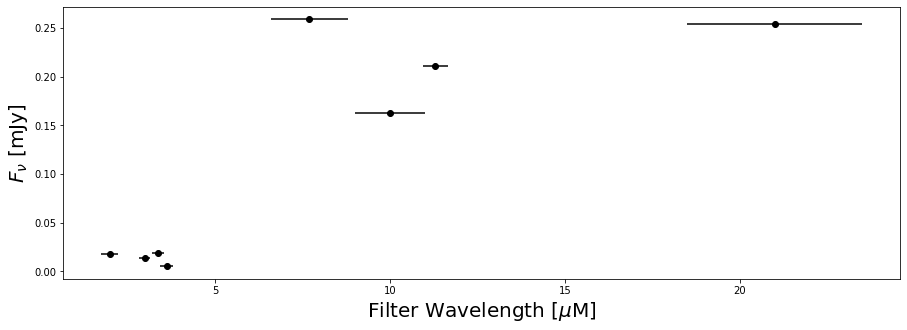

In [73]:
# SED plot 

err_lambda = [x/2. for x in delta_lambda]
plt.figure(figsize = (15,5))
plt.scatter(lambda_0,flux, color='black')
plt.errorbar(lambda_0,flux, xerr = err_lambda, fmt='', ls="", color="black")
plt.xlabel("Filter Wavelength [$\mu$M]", fontsize = 20)
plt.ylabel(r"$F_\nu$ [mJy]", fontsize=20)



In [53]:
sumLum = np.sum(NuLnu)
print("Sum of Nu L_nu = :",np.round(sumLum,3)," x 10^5 L_sun") 

Sum of Nu L_nu = : 29.6  x 10^5 L_sun


In [88]:
fluxTable = Table({"Image":titles,
                   "R.A. Center [dec deg]":ras,
                   "Dec Center [dec deg]": decs,
                   "Aperature Radius [arcsec]": angRads,
                   "Ness Flux [mJy]": flux,
                   "Nils Flux [mJy]": NilsFlux,
                   "Adam Flux [mJy]": AdamFlux,
                   "Delta_nu L_nu [10^5 L_sun]": DeltanuLnu
})

fluxTable = Table({"Filter":titles,
                    "Lambda":lambda_0,
                   "Delta_lambda":delta_lambda,
                   "Ness Flux [mJy]": flux,
                   "Nils Flux [mJy]": NilsFlux,
                   "Adam Flux [mJy]": AdamFlux,
                    "Nu L_nu [10^5 L_sun]": NuLnu,
                   "Delta_nu L_nu [10^5 L_sun]": DeltanuLnu
})



In [89]:
ascii.write(fluxTable, "../Data/1.SN2021aefx.tex", format="latex", overwrite=True)

In [82]:

if os.path.isfile('./aperture_correction_table.txt'):
    ap_tab = './aperture_correction_table.txt'
else:
    print("Downloading the aperture correction table")

    boxlink_apcorr_table = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/aperture_correction_table.txt'
    boxfile_apcorr_table = './aperture_correction_table.txt'
    urllib.request.urlretrieve(boxlink_apcorr_table, boxfile_apcorr_table)
    ap_tab = './aperture_correction_table.txt'

aper_table = pd.read_csv(ap_tab, header=None, sep='\s+', index_col=0,
                         names=['filter', 'pupil', 'wave', 'r10', 'r20', 'r30', 'r40', 'r50', 'r60', 'r70', 'r80',
                                'r85', 'r90', 'sky_flux_px', 'apcorr10', 'apcorr20', 'apcorr30', 'apcorr40',
                                'apcorr50', 'apcorr60', 'apcorr70', 'apcorr80', 'apcorr85', 'apcorr90', 'sky_in',
                                'sky_out'], comment='#', skiprows=0, usecols=range(0, 26))
aper_table


AttributeError: 'float' object has no attribute 'read_csv'

In [ ]:
from getMapValue import getValue
from isCoordInMap import isInMap

getValue(file, ra, dec)
isInMap(file, ra, dec)